# Histopathologic Cancer Detection
## [Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)

### PURPOSE
The challenge of this competition is "to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)." 

### DATASET
The dataset is provided by Bas Veeling, Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. The dataset is described in detail in their papers [*Rotation Equivariant CNNs for Digital Pathology*](https://arxiv.org/abs/1806.03962) and [*Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer*](https://jamanetwork.com/journals/jama/fullarticle/2665774).

### MODELLING APPROACH
Three convolutional neural networks are trained below. Model 2 had the best prediction accuracy and Kaggle score. Model 2 is a convolutional neural network (CNN) with 3 convolutional layers, 3 max pooling layers, and 1 fully connected layer. The model was trained for 20 epochs on 198022 images with the Adam optimizer, the .001 default learning rate, and a batch size of 32 images. The model was validated on 22003 images. Model 2 is saved as HCD_model2.h5 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

### Import image paths and labels

In [70]:
# Train Data
df = pd.read_csv('train_labels.csv')

# Add image path to dataframe
df['image_path'] = 'train/' + df['id'] + '.tif'

# Convert labels to string
df['label'] = df['label'].astype(str)

# Test Data
df_test = pd.read_csv('sample_submission.csv')
df_test['image_path'] = 'test/' + df_test.id + '.tif'

### Inspect Data

Train samples:  220025
Train header and first two rows:


,id,label,image_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,train/f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif


Train sample image:


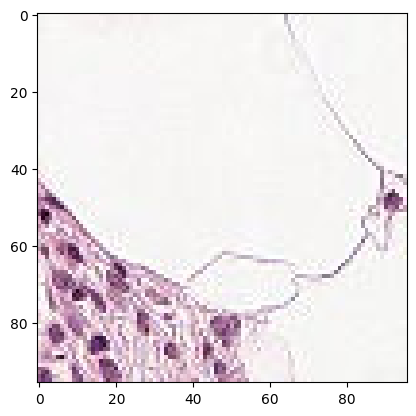

In [86]:
# Train data
print("Train samples: ", df.shape[0])
print("Train header and first two rows:")
display(df.head(2))

# Sample train image
print("Train sample image:")
img = mpimg.imread(df['image_path'][0])
plt.imshow(img)

Test samples (57458, 3)
Test header and first two rows


,id,label,image_path
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,test/0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,test/95596b92e5066c5c52466c90b69ff089b39f2737.tif


Test sample image:


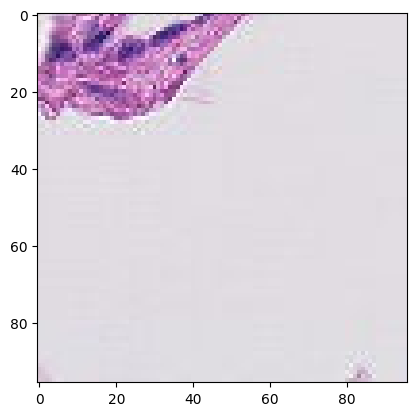

In [88]:
# Test data
print("Test samples", df_test.shape)
print("Test header and first two rows")
display(df_test.head(2))

# Sample test image
print("Test sample image:")
img = mpimg.imread(df_test['image_path'][0])
plt.imshow(img)


### Split train into train and validation sets


In [ ]:
train_df, val_df = train_test_split(df, test_size = 0.1)

### Create image generators

In [19]:
# Generator specifications
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Train generator
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col = 'image_path', 
                                                    y_col = 'label', 
                                                    target_size = (96, 96), 
                                                    batch_size = 32, 
                                                    class_mode = 'binary')

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'binary')


# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'image_path',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = None,
    shuffle = False)    

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.
Found 0 images belonging to 0 classes.


## CNN Modelling

### Model 1: Architecture

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Model 1: Train

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_df)//32,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = len(val_df)//32)

Epoch 1/20
6188/6188 [==============================] - 416s 67ms/step - loss: 0.2243 - accuracy: 0.9139 - val_loss: 0.2099 - val_accuracy: 0.9197
Epoch 2/20
6188/6188 [==============================] - 386s 62ms/step - loss: 0.2207 - accuracy: 0.9157 - val_loss: 0.2155 - val_accuracy: 0.9207
Epoch 3/20
6188/6188 [==============================] - 397s 64ms/step - loss: 0.2158 - accuracy: 0.9178 - val_loss: 0.1959 - val_accuracy: 0.9263
Epoch 4/20
6188/6188 [==============================] - 399s 64ms/step - loss: 0.2141 - accuracy: 0.9184 - val_loss: 0.2229 - val_accuracy: 0.9150
Epoch 5/20
6188/6188 [==============================] - 453s 73ms/step - loss: 0.2086 - accuracy: 0.9209 - val_loss: 0.2492 - val_accuracy: 0.9071
Epoch 6/20
6188/6188 [==============================] - 411s 66ms/step - loss: 0.2106 - accuracy: 0.9202 - val_loss: 0.2057 - val_accuracy: 0.9224
Epoch 7/20
6188/6188 [==============================] - 406s 66ms/step - loss: 0.2054 - accuracy: 0.9231 - val_loss: 0

#### Model 1: Performance

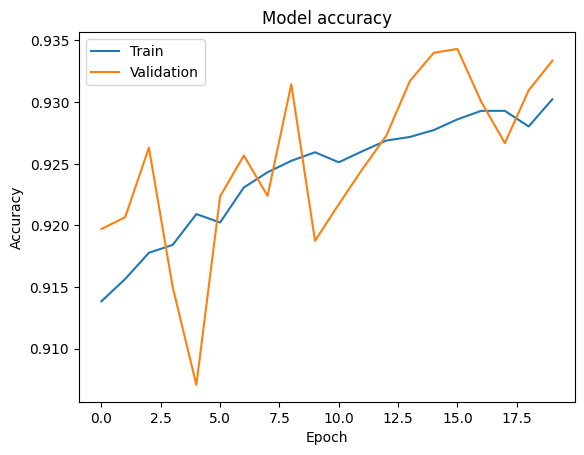

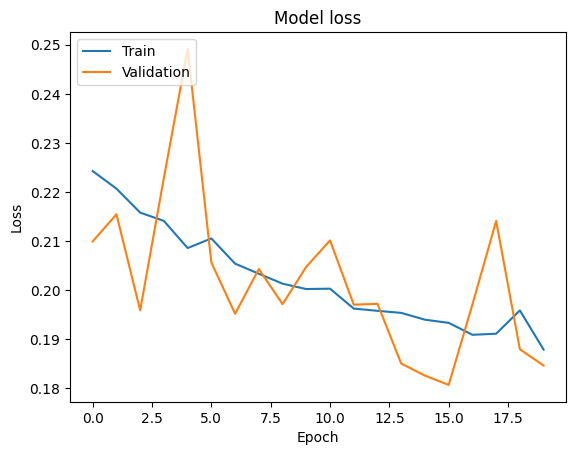

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Model 1: Save

In [18]:
model.save('HCD_model.h5')

/Users/stevenhobbs/.pyenv/versions/3.11.1/envs/DataMiningPipeline/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 1: Predict on the Test Data

In [41]:
test_probs = model.predict(test_generator)

# Create submission file for Kaggle
submission = pd.read_csv('sample_submission.csv')
submission['label'] = test_probs
print(submission.head())
submission.to_csv('submission1.csv', header = True, index = False)

                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.001895
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.000116
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.021352
3  2c35657e312966e9294eac6841726ff3a748febf  0.004197
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.008636


### Model 2: Architecture (Best model)
Model 2 is a more regularized version of model 1 with dropout components added to each convolutions layers.

In [42]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model 2: Train

In [43]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch = len(train_df)//32,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = len(val_df)//32)

Epoch 1/20
6188/6188 [==============================] - 429s 69ms/step - loss: 0.4150 - accuracy: 0.8154 - val_loss: 0.3682 - val_accuracy: 0.8336
Epoch 2/20
6188/6188 [==============================] - 439s 71ms/step - loss: 0.3447 - accuracy: 0.8542 - val_loss: 0.3100 - val_accuracy: 0.8753
Epoch 3/20
6188/6188 [==============================] - 429s 69ms/step - loss: 0.3240 - accuracy: 0.8652 - val_loss: 0.3289 - val_accuracy: 0.8576
Epoch 4/20
6188/6188 [==============================] - 434s 70ms/step - loss: 0.3127 - accuracy: 0.8717 - val_loss: 0.2918 - val_accuracy: 0.8776
Epoch 5/20
6188/6188 [==============================] - 1217s 197ms/step - loss: 0.3013 - accuracy: 0.8764 - val_loss: 0.3240 - val_accuracy: 0.8577
Epoch 6/20
6188/6188 [==============================] - 924s 149ms/step - loss: 0.2947 - accuracy: 0.8798 - val_loss: 0.2853 - val_accuracy: 0.8794
Epoch 7/20
6188/6188 [==============================] - 1442s 233ms/step - loss: 0.2898 - accuracy: 0.8820 - val_lo

### Model 2: Performance

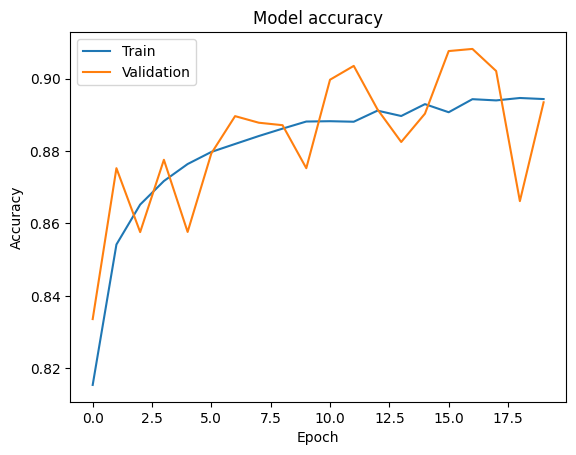

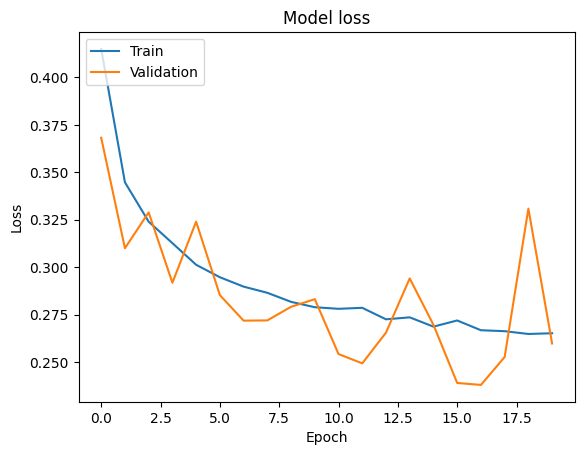

In [44]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 2: Save

In [89]:
model2.save('HCD_model2.h5')

/Users/stevenhobbs/.pyenv/versions/3.11.1/envs/DataMiningPipeline/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 2: Predict on the Test Data

In [45]:
test_probs2 = model2.predict(test_generator)

submission2 = pd.read_csv('sample_submission.csv')
submission2['label'] = test_probs2
print(submission2.head())
submission2.to_csv('submission2.csv', header = True, index = False)

1796/1796 [==============================] - 44s 25ms/step
                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.017566
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.199028
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.034102
3  2c35657e312966e9294eac6841726ff3a748febf  0.250915
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.124385


### Model 3 - Transfer Learning (Model 2 extension)

In [50]:
model3 = Sequential()

# Add layers from model2 up to the last dropout layer
for layer in model2.layers[:-4]:
    model3.add(layer)

# Freeze the model2 layers
for layer in model3.layers:
    layer.trainable = False

# Add a new Conv2D layer
model3.add(Conv2D(256, (3,3), activation = 'relu'))
MaxPooling2D((2,2))
Dropout(0.5)

# Add a new fully connected layer
model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))
Dropout(0.5)

# Add a new output layer
model3.add(Dense(1, activation = 'sigmoid'))

# Compile model 3
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model 3: Train

In [51]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch = len(train_df)//32,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = len(val_df)//32)

Epoch 1/20
6188/6188 [==============================] - 239s 39ms/step - loss: 0.2482 - accuracy: 0.8994 - val_loss: 0.2616 - val_accuracy: 0.8920
Epoch 2/20
6188/6188 [==============================] - 243s 39ms/step - loss: 0.2368 - accuracy: 0.9046 - val_loss: 0.2554 - val_accuracy: 0.8976
Epoch 3/20
6188/6188 [==============================] - 241s 39ms/step - loss: 0.2342 - accuracy: 0.9058 - val_loss: 0.2597 - val_accuracy: 0.8989
Epoch 4/20
6188/6188 [==============================] - 239s 39ms/step - loss: 0.2314 - accuracy: 0.9075 - val_loss: 0.2559 - val_accuracy: 0.8995
Epoch 5/20
6188/6188 [==============================] - 242s 39ms/step - loss: 0.2294 - accuracy: 0.9080 - val_loss: 0.2472 - val_accuracy: 0.9010
Epoch 6/20
6188/6188 [==============================] - 238s 38ms/step - loss: 0.2303 - accuracy: 0.9085 - val_loss: 0.2439 - val_accuracy: 0.9032
Epoch 7/20
6188/6188 [==============================] - 240s 39ms/step - loss: 0.2287 - accuracy: 0.9080 - val_loss: 0

### Model 3: Performance

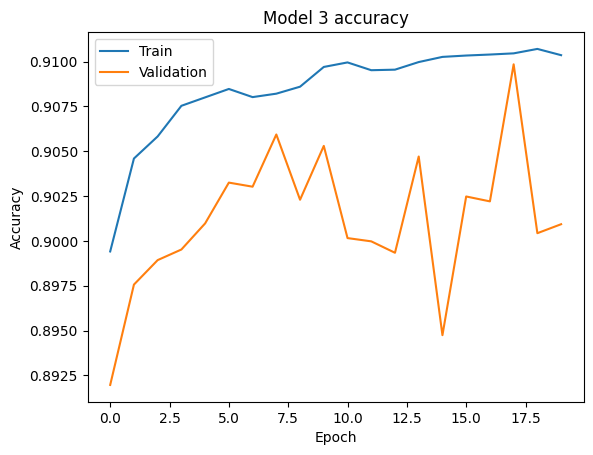

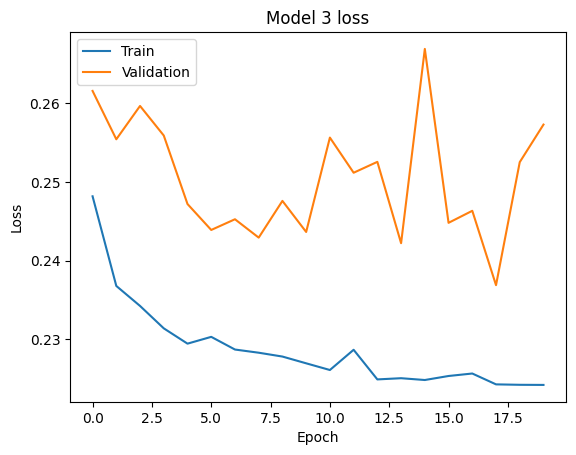

In [52]:
# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 3: Save

In [53]:
model3.save('HCD_model3.h5')

/Users/stevenhobbs/.pyenv/versions/3.11.1/envs/DataMiningPipeline/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 3: Predict on the Test Data

In [54]:
test_probs3 = model3.predict(test_generator)

# Create submission file for Kaggle
submission3 = pd.read_csv('sample_submission.csv')
submission3['label'] = test_probs3
print(submission3.head())
submission3.to_csv('submission3.csv', header = True, index = False)

1796/1796 [==============================] - 86s 48ms/step
                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.003264
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.195236
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.015776
3  2c35657e312966e9294eac6841726ff3a748febf  0.115458
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.084156


# Results

The three CNN models all performed reasonably well. Model 2 had the best performance with train and validation accuracies that were both above 89%. Model 2 also had the best Kaggle private score of 0.901. Model 3 had the best train and validation accuracies that were both above 90%. However, model 3 had worse performance on unseen data with a Kaggle private score of 0.8939. Model 1 had the highest train and validation accuracies, both above 93%, but the worst Kaggle private score of 88%.  Model 1 and 3 are overfit to the training data. 

# Discussion

Model 2 was produced by doubling the training epochs and adding dropout layers to model 1, which appears to have addressed the overfitting issue. If I were to spend more time on this project, I would experiment with different dropout rates, regularization techniques, optimization algorithms, and larger convolutional layers to see if I could improve the performance of model 2. 